# IMPLEMENTING DECISION TREES


In [33]:
# importing dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
iris = load_iris()

In [28]:
col = ['sepal_length', 'sepal_width', 'petal_length','petal_width']
df_features = pd.DataFrame(data=iris.data, columns=col)

# Create a DataFrame for the target variable (species)
df_target = pd.DataFrame(data=iris.target, columns=['type'])

# Concatenate the feature DataFrame and the target variable DataFrame along the columns
df = pd.concat((df_features, df_target), axis=1)

In [29]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,type
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [30]:
df.info()
# we see that there are no null values in our data, 
# and all the variables are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   type          150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [31]:
# Our data has numerical values for the type of flower they are:
df['type'].unique()
# 0: Setosa
# 1: Versicolor
# 2: Virginica

array([0, 1, 2])

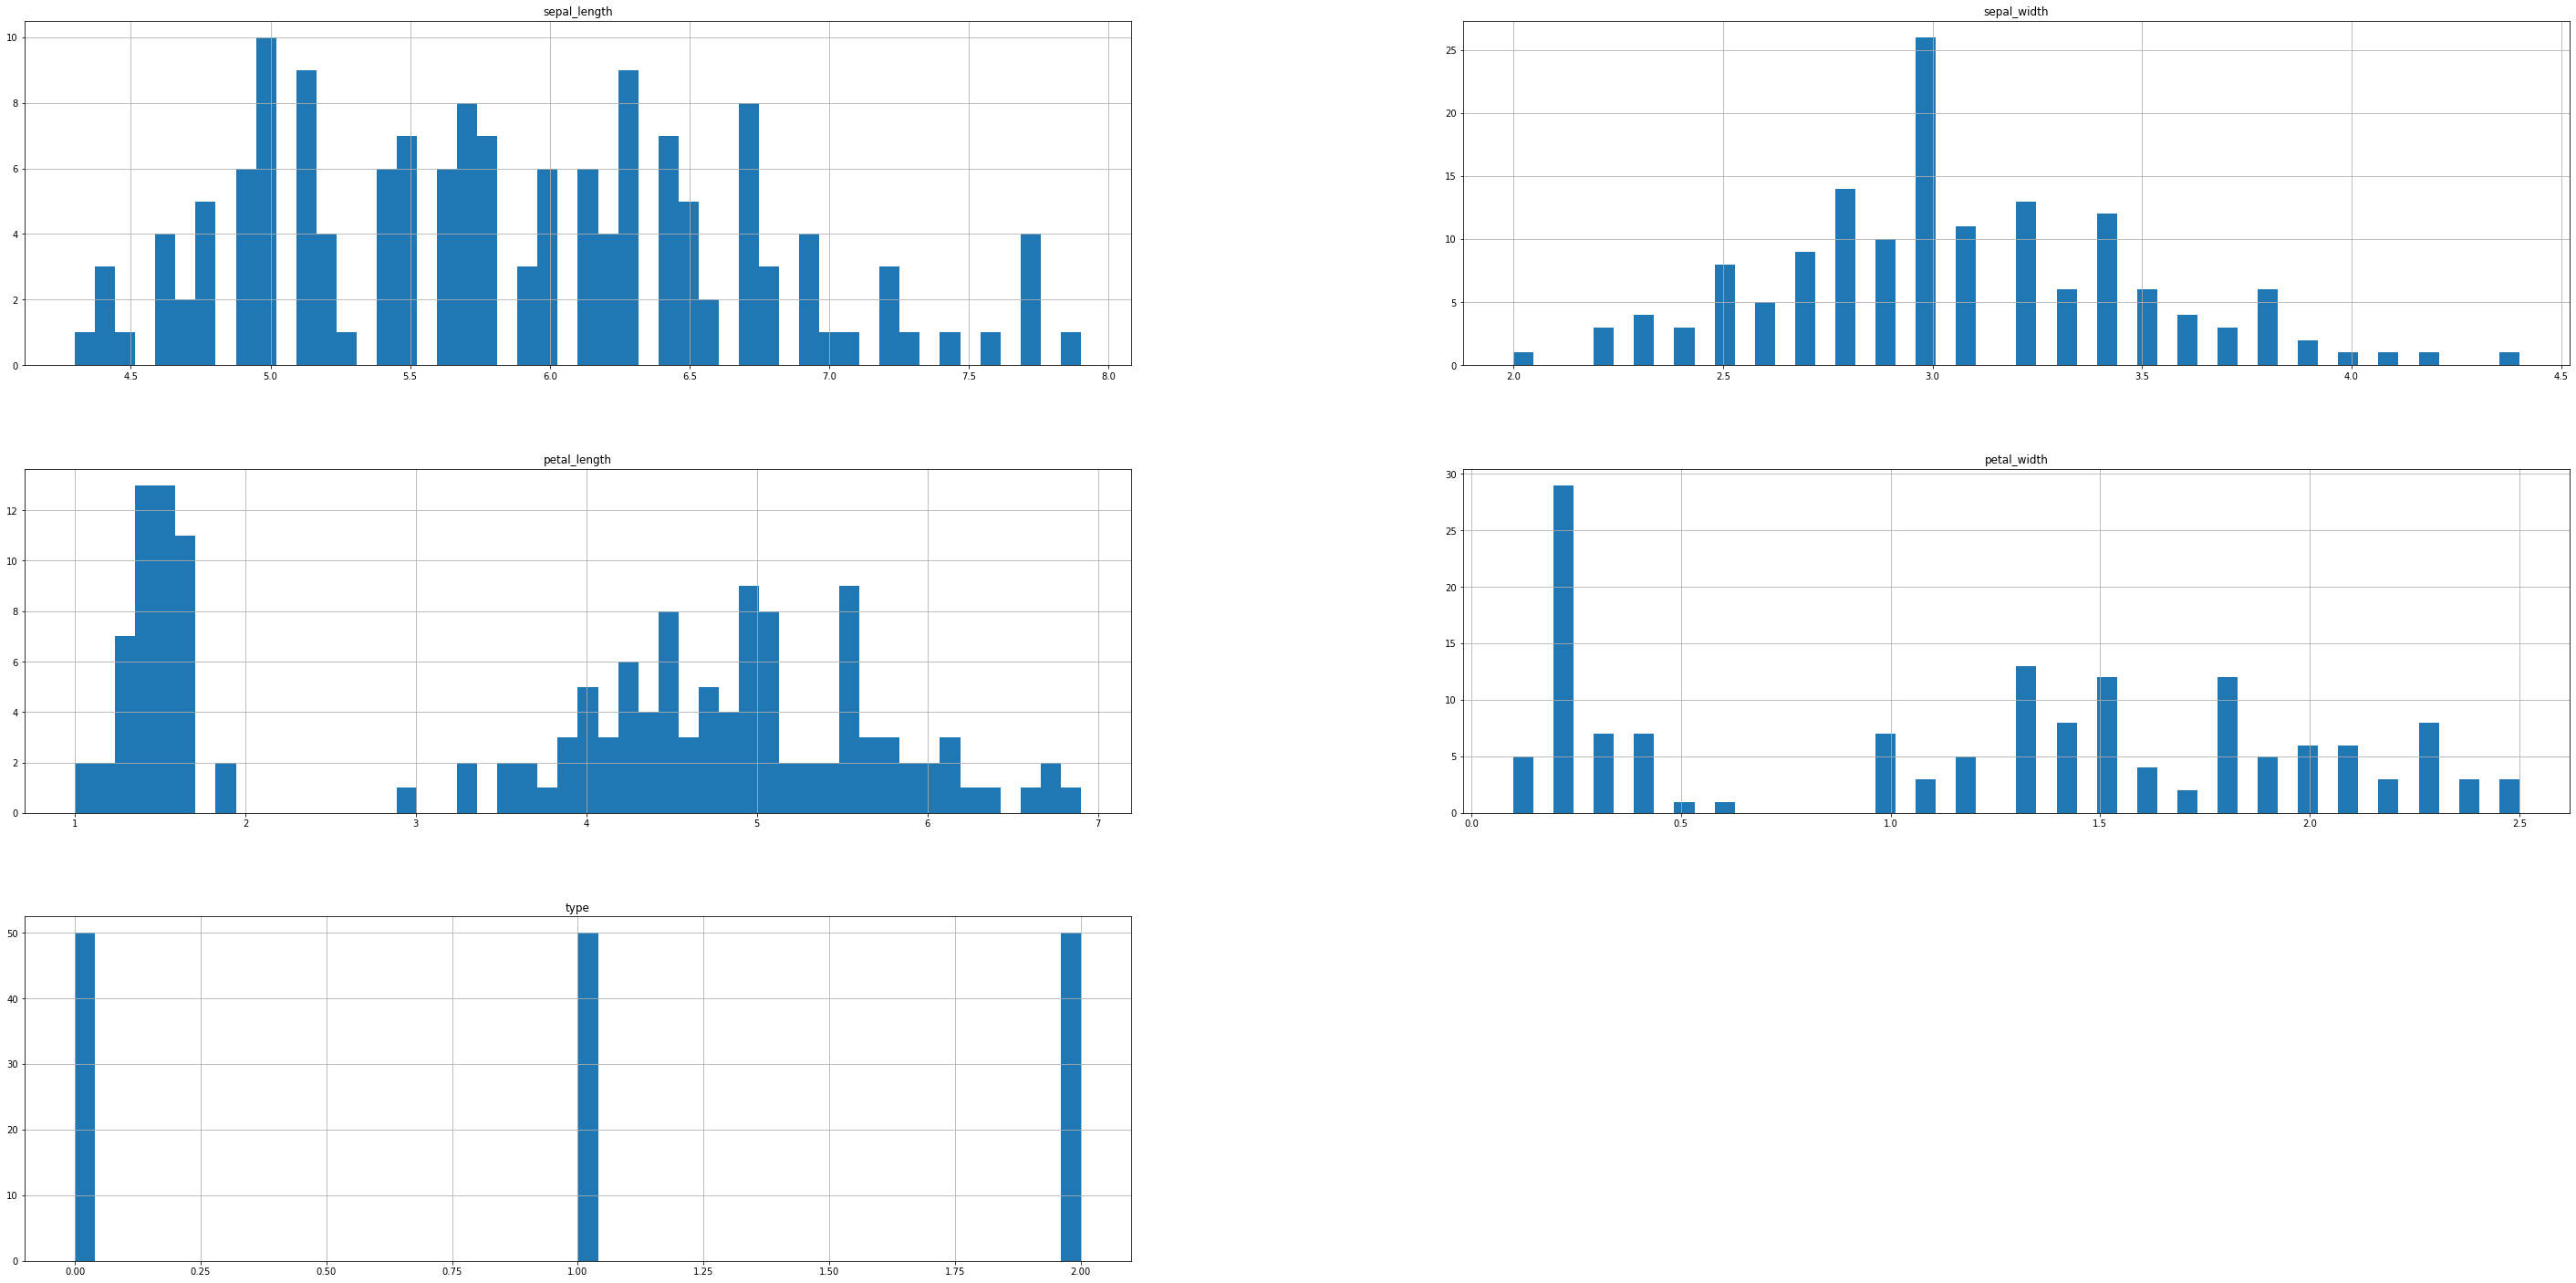

In [32]:
# this is a simple data exploration, here i am including some histograms and scatterplots
df.hist(bins=50, figsize=(50,25))
plt.show()

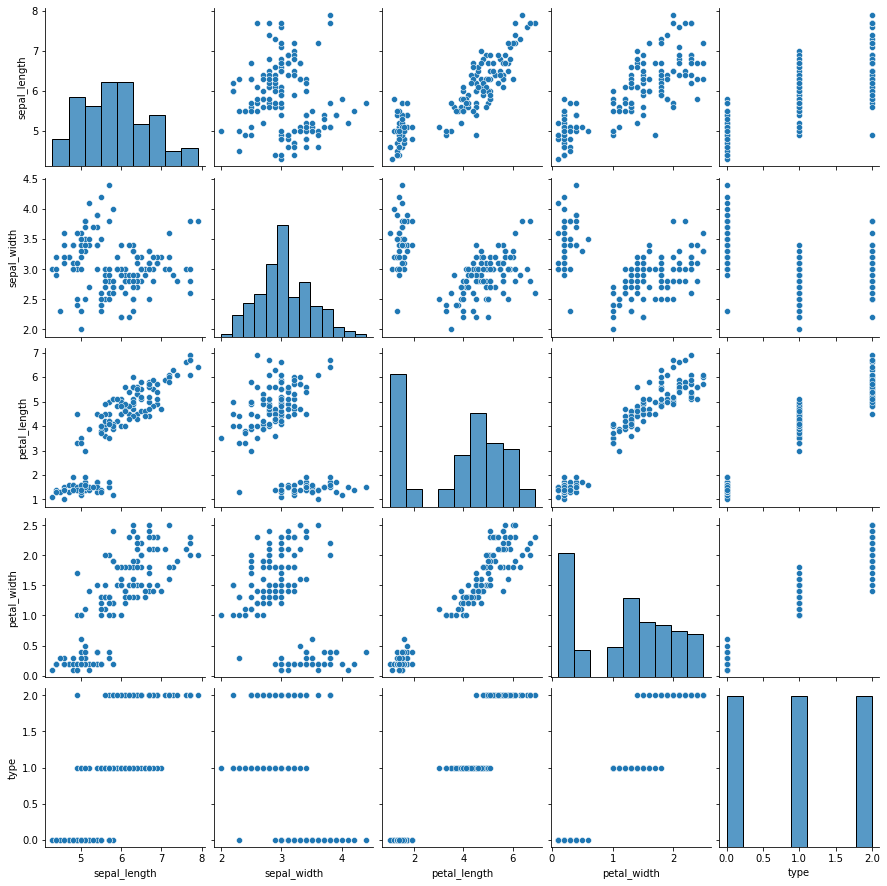

In [34]:
sns.pairplot(df)
plt.show()

## DECISION TREE ALGORITHM

In [36]:
# this is a class to create nodes
class Node():
    # here i am constructing variables to use them globally in the further functions
    def __init__(self, main_index = None, weight = None, left = None, right = None, gain_info = None, value = None):
        
        # for decision node
        self.main_index = main_index
        self.weight = weight
        self.left = left
        self.right = right
        self.gain_info = gain_info
        
        # for leaf node
        self.value = value

class Decision_tree():
    
    # here i am creating the varibales that will be used in the algorithm    
    def __init__(self, minimum_samples_split = 2, maximum_depth = 2):
        
        self.root = None
        
        self.minimum_samples_split = minimum_samples_split
        self.maximum_depth = maximum_depth
        
    def building_tree(self, data, current_depth = 0):
        # this function is recursively used to build the tree.
        
        X,Y = data[:,:-1], data[:,-1]
        
        num_samp , no_feature = np.shape(X)
        
        if num_samp >= self.minimum_samples_split and current_depth <= self.maximum_depth:
            good_split = self.get_good_split(data, num_samp, no_feature)
            
            if good_split['gain_info'] > 0:
                
                left_subtree = self.building_tree(good_split['data_left'], current_depth + 1)
                
                right_subtree = self.building_tree(good_split['data_right'], current_depth + 1)
                
                return Node(good_split['main_index'] , good_split['weight'], left_subtree, right_subtree, good_split['gain_info'])
                
        
        
        #computing leaf node
        leaf_value = self.cal_leaf_val(Y)
        
        # return leaf node
        return Node(value = leaf_value)
    
    def get_good_split(self, data, num_samp, no_feature):
        good_split = {}
        
        max_gain_info = -float("inf")
        
        for main_index in range(no_feature):
            
            feature_values = data[:, main_index]
            
            possible_weights = np.unique(feature_values)
            
            for weight in possible_weights:
                
                data_left, data_right = self.split(data, main_index, weight)
                
                if len(data_left) > 0 and len(data_right) > 0:
                    
                    y, left_y, right_y = data[:,-1], data_left[:,-1], data_right[:,-1]
                    
                    curr_gain_info = self.information_gain(y, left_y, right_y, "gini")
                    
                    if curr_gain_info > max_gain_info:
                        
                        good_split["main_index"] = main_index
                        good_split["weight"] = weight
                        good_split["data_left"] = data_left
                        good_split["data_right"] = data_right
                        good_split["gain_info"] = curr_gain_info
                        max_gain_info = curr_gain_info
                        
        return good_split
    
    # this function is used to split the condition
    def split(self, data, main_index, weight):
        
        data_left = np.array([row for row in data if row[main_index]<=weight])
        data_right = np.array([row for row in data if row[main_index]> weight])
        
        return data_left, data_right
    
    # this is to calculate the information gain
    def information_gain(self, parent, l_child, r_child, mode = "entropy"):
        # function to compute the information gain
        
        weight_l = len(l_child) /len(parent)
        weight_r = len(r_child) / len(parent)
        
        if mode == "gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r * self.gini_index(r_child))
            
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
            
        return gain
    
    # calculating gini
    def entropy(self,y):
        
        cls_labels = np.unique(y)
        entropy = 0
        for t in cls_labels:
            p_t = len(y[y == t]) /len(y)
            entropy += -p_t * np.log2(p_t)
        return entropy
    
   
    def gini_index(self,y):
        
        cls_labels = np.unique(y)
        gini = 0
        for t in cls_labels:
            p_t = len(y[y == t]) / len(y)
            gini += p_t ** 2
        
        return 1 - gini
    
    def cal_leaf_val(self, Y):
        
        Y = list(Y)
        return max(Y, key = Y.count)
    
        
    def fit(self, X, Y):
        
        data = np.concatenate(( X, Y), axis = 1)
        self.root = self.building_tree(data)
        
    def predict(self, X):
        
        predictions = [self.testing(x, self.root) for x in X]
        return predictions
    
    def testing(self,x, tree):
        
        if tree.value != None : 
            return tree.value
        feature_val = x[tree.main_index]
        if feature_val <= tree.weight:
            return self.testing(x, tree.left)
        else:
            return self.testing(x, tree.right)
            

In [37]:
# Train and Test Split

X = df.iloc[:, :-1].values
Y = df.iloc[:,-1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = .2, random_state = 41)

In [38]:
# here i am creating an object to call function in the class decision tree
classifier = Decision_tree(minimum_samples_split = 3, maximum_depth = 3)

# here i am calling the funciton fit to give the data to the algorithm
classifier.fit(X_train, Y_train)

In [39]:
# Testing the model using sklearn
Y_pred = classifier.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, Y_pred)

0.9333333333333333